In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import (OneHotEncoder,
                                    LabelEncoder,
                                    OrdinalEncoder,
                                    StandardScaler, 
                                    MinMaxScaler,
                                    RobustScaler,
                                    FunctionTransformer)

from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from sklearn.linear_model import(LinearRegression, 
                                 Lasso, 
                                 Ridge,
                                 ElasticNet)
from sklearn.ensemble import(RandomForestRegressor, 
                            GradientBoostingRegressor, 
                            AdaBoostRegressor)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import(r2_score,
                            root_mean_squared_error,
                            mean_absolute_error)
from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('/Users/suryasaikadali/Downloads/pw_skills/kaggle/insurance_prediction/artifacts/insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [4]:
df['bmi'] = np.sqrt(df['bmi'])

In [5]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [6]:
df['sex'] = df['sex'].map({'female':0, 'male':1})
df['smoker'] = df['smoker'].map({'no':0, 'yes':1})
df['region'] = df['region'].map({'southwest':0,
                                 'southeast':1,
                                 'northwest':2,
                                 'northeast':3 })

In [7]:
df['sex'].dtype

dtype('int64')

In [8]:
x = df.drop(['expenses'], axis = 1)

In [9]:
y = df[['expenses']]

In [10]:
x_train,x_test,y_train,y_test = train_test_split(x, y,
                                                 test_size = 0.25, random_state = 0)

In [11]:
x.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [12]:
pipeline = Pipeline(
    steps = [
        ('standard_scaler',StandardScaler())
    ]
)

In [13]:
x_train_new = pd.DataFrame(pipeline.fit_transform(x_train),
                           columns = x.columns)
x_test_new = pd.DataFrame(pipeline.transform(x_test),
                          columns = x.columns)

In [14]:
x_train_new 

,age,sex,bmi,children,smoker,region
0,-0.514853,-0.985155,-0.130877,-0.063607,-0.503736,-0.390781
1,1.548746,-0.985155,-1.465482,-0.892144,-0.503736,1.419629
2,-1.439915,1.015069,-0.986161,-0.063607,-0.503736,-1.295987
3,-1.368757,-0.985155,-1.022104,-0.892144,1.985167,-0.390781
4,-0.941805,-0.985155,-1.427638,-0.892144,-0.503736,0.514424
...,...,...,...,...,...,...
998,-0.870646,1.015069,-0.738550,-0.892144,-0.503736,1.419629
999,0.196733,1.015069,0.864353,0.764931,-0.503736,-0.390781
1000,0.054415,1.015069,-0.896939,-0.892144,-0.503736,-0.390781
1001,-1.439915,1.015069,0.789966,-0.892144,-0.503736,0.514424


In [15]:
sample_col = ['bmi','age','children']

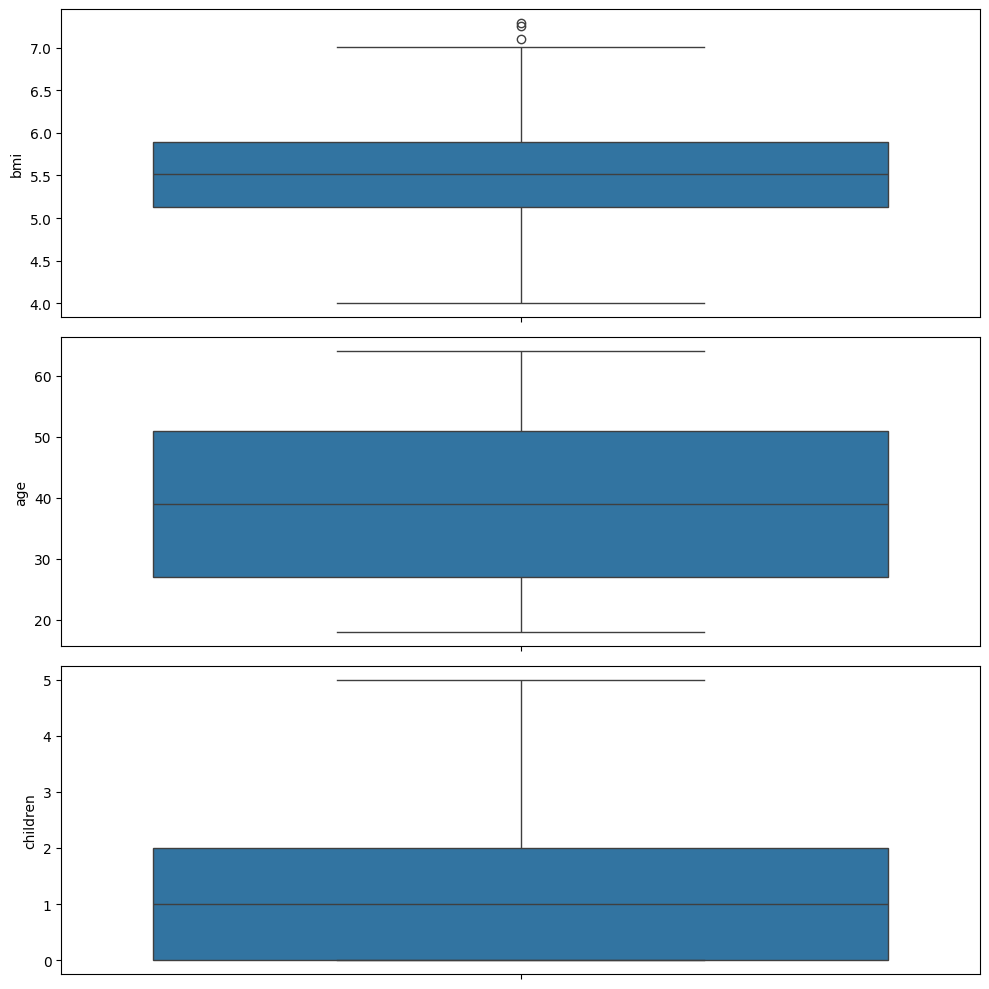

In [16]:
plt.figure(figsize = (10,10))
for i,col in enumerate(sample_col):
    plt.subplot(3,1,i+1)
    sns.boxplot(df, y = col)
    plt.tight_layout()

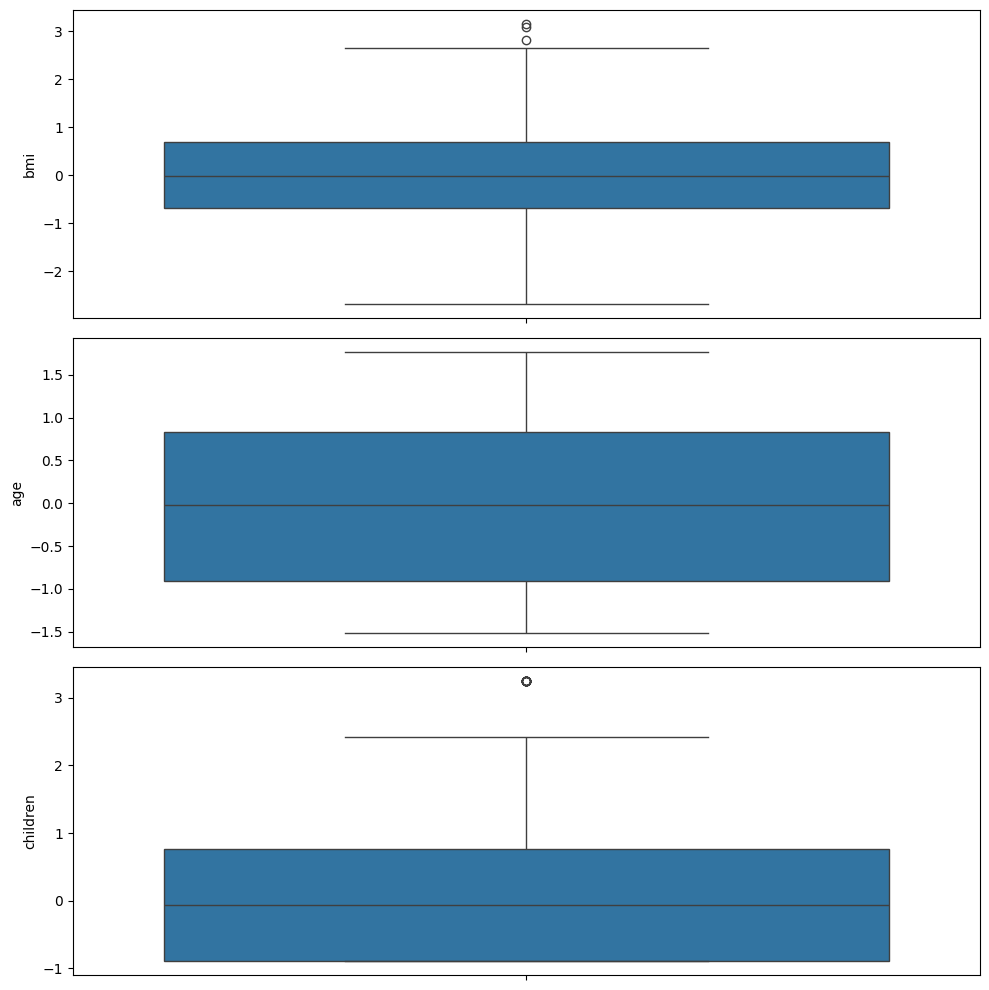

In [17]:
plt.figure(figsize = (10,10))
for i,col in enumerate(sample_col):
    plt.subplot(3,1,i+1)
    sns.boxplot(x_train_new, y = col)
    plt.tight_layout()

In [18]:
x_train_new.columns[1]

'sex'

In [19]:
scores = mutual_info_regression(x_train_new,y_train)

In [20]:
scores

array([1.41620784, 0.11466168, 0.09631152, 0.14684695, 0.36809762,
       0.0732808 ])

In [21]:
ab = {}
for i,score in enumerate(scores):
    ab.update({x_train_new.columns[i]:score})

In [22]:
ab

{'age': 1.4162078416892654,
 'sex': 0.11466168262737875,
 'bmi': 0.0963115247147357,
 'children': 0.14684695203868436,
 'smoker': 0.3680976183770448,
 'region': 0.07328079506889296}

In [23]:
sorted_ab = sorted(ab.items(), key = lambda item:item[1],reverse = True)

In [24]:
sorted_ab

[('age', 1.4162078416892654),
 ('smoker', 0.3680976183770448),
 ('children', 0.14684695203868436),
 ('sex', 0.11466168262737875),
 ('bmi', 0.0963115247147357),
 ('region', 0.07328079506889296)]

<Axes: >

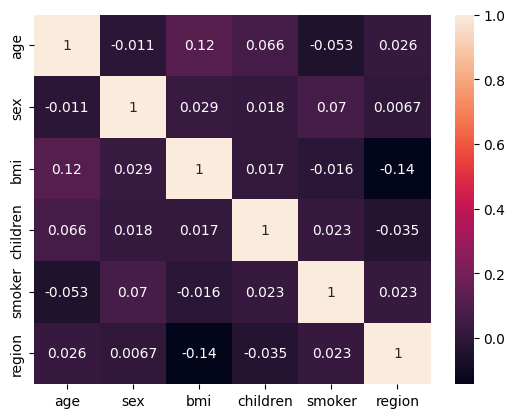

In [25]:
sns.heatmap(x_train_new.corr(), annot = True)

<Axes: xlabel='sex', ylabel='expenses'>

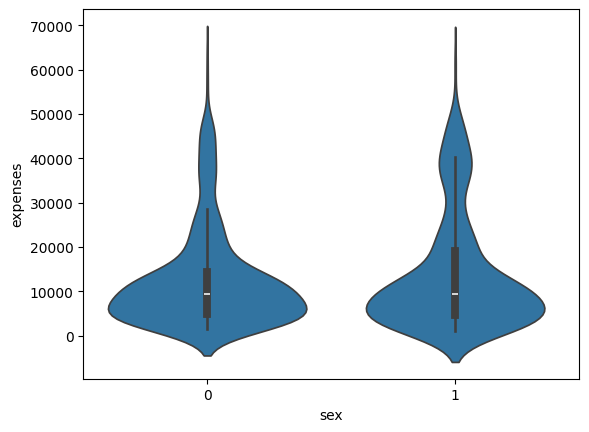

In [26]:
sns.violinplot(df, 
               x = 'sex',
               y = 'expenses')

In [27]:
models = {
    'linear':LinearRegression(),
    'Lasso':Lasso(),
    'ridge':Ridge(),
    'random':RandomForestRegressor(random_state = 13),
    'xg':XGBRegressor(random_state = 42),
    'Gradient':GradientBoostingRegressor(random_state = 42),
    'knn': KNeighborsRegressor()
}

In [42]:
def evaluation(x_train, x_test, y_train, y_test, models):
    for key,value in models.items():
        model = value.fit(x_train,y_train)
        y_predict_test = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        
        r2_train = r2_score(y_true = y_train,
                            y_pred = y_pred_train)
        
        r2 = r2_score(y_true = y_test,
                      y_pred = y_predict_test)
        
        rmse = root_mean_squared_error(y_true = y_test,
                                       y_pred = y_predict_test)
        mae = mean_absolute_error(y_true = y_test,
                                  y_pred = y_predict_test)
        print(key)
        print(f'r2_score_train : {r2_train}')
        print(f'r2_score : {r2}')
        print(f'RMSE : {rmse}')
        print(f'MAE : {mae}')
        print("%%%%%%%%%%%")

In [43]:
evaluation(x_train_new, x_test_new, y_train, y_test, models)

linear
r2_score_train : 0.7344316711617922
r2_score : 0.796059482932696
RMSE : 5666.328268922168
MAE : 4044.0755060369565
%%%%%%%%%%%
Lasso
r2_score_train : 0.7344316307227268
r2_score : 0.7960494786400388
RMSE : 5666.467247953712
MAE : 4043.9505491623663
%%%%%%%%%%%
ridge
r2_score_train : 0.7344309094308847
r2_score : 0.7959920404104912
RMSE : 5667.265110425578
MAE : 4046.2146461485413
%%%%%%%%%%%
random
r2_score_train : 0.9751029122307874
r2_score : 0.871013014179342
RMSE : 4506.329253126539
MAE : 2759.6212876019904
%%%%%%%%%%%
xg
r2_score_train : 0.9952712059020996
r2_score : 0.8287116289138794
RMSE : 5192.947117225039
MAE : 3222.233676382492
%%%%%%%%%%%
Gradient
r2_score_train : 0.8951649096532505
r2_score : 0.8972431932703069
RMSE : 4022.1223076929796
MAE : 2431.7848680859843
%%%%%%%%%%%
knn
r2_score_train : 0.861926199087774
r2_score : 0.8495439365060587
RMSE : 4866.926867393397
MAE : 3194.583880597015
%%%%%%%%%%%


In [30]:
gr_params = {
    'learning_rate':[0.05,0.1],
    'n_estimators': list(np.arange(100,401,50)),
    'max_depth': list(np.arange(1,8,2)),
    'criterion': ['squared_error', 'friedman_mse']
}

rf_params = {
    'n_estimators' : list(np.arange(100,401,50)),
    'criterion' : ['squared_error', 'friedman_mse', 'poisson'],
    'max_depth' : list(np.arange(1,8,2))


}

In [31]:
gr_boost = GridSearchCV(estimator = models['Gradient'],
                        param_grid = gr_params, 
                        cv = 10,
                        scoring = 'r2',
                        verbose = 3)

rf_grid = GridSearchCV(estimator = models['random'],
                        param_grid = rf_params, 
                        cv = 10,
                        scoring = 'r2',
                        verbose = 3)

In [32]:
gr_boost.fit(x_train_new,y_train)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
[CV 1/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.764 total time=   0.0s
[CV 2/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.758 total time=   0.0s
[CV 3/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.644 total time=   0.0s
[CV 4/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.692 total time=   0.0s
[CV 5/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.615 total time=   0.0s
[CV 6/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.761 total time=   0.0s
[CV 7/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.684 total time=   0.0s
[CV 8/10] END criterion=squared_error, learning_rate=0.05, max_depth=1, n_estimat

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'learning_rate': [0.05, 0.1],
                         'max_depth': [1, 3, 5, 7],
                         'n_estimators': [100, 150, 200, 250, 300, 350, 400]},
             scoring='r2', verbose=3)

In [33]:
rf_grid.fit(x_train_new,y_train)

Fitting 10 folds for each of 84 candidates, totalling 840 fits
[CV 1/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.716 total time=   0.0s
[CV 2/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.671 total time=   0.0s
[CV 3/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.494 total time=   0.0s
[CV 4/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.486 total time=   0.0s
[CV 5/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.411 total time=   0.0s
[CV 6/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.676 total time=   0.0s
[CV 7/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.615 total time=   0.0s
[CV 8/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.590 total time=   0.0s
[CV 9/10] END criterion=squared_error, max_depth=1, n_estimators=100;, score=0.593 total time=   0.0s
[CV 10/10] END crit

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=13),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'poisson'],
                         'max_depth': [1, 3, 5, 7],
                         'n_estimators': [100, 150, 200, 250, 300, 350, 400]},
             scoring='r2', verbose=3)

In [34]:
best_gr = gr_boost.best_params_

In [35]:
best_rf = rf_grid.best_params_

In [36]:
best_gr

{'criterion': 'squared_error',
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 100}

In [37]:
best_rf

{'criterion': 'poisson', 'max_depth': 3, 'n_estimators': 150}

In [38]:
gr_boost.best_score_

0.8389496921622286

In [39]:
rf_grid.best_score_

0.8335609931727468

In [40]:
new_models = {
    'best_gradient' : GradientBoostingRegressor(**best_gr),
    'best_random forest' : RandomForestRegressor(**best_rf)
}


In [44]:
evaluation(x_train_new, x_test_new, y_train, y_test, new_models)

best_gradient
r2_score_train : 0.8763964843069415
r2_score : 0.9011135908437893
RMSE : 3945.647437328448
MAE : 2469.497107032847
%%%%%%%%%%%
best_random forest
r2_score_train : 0.8489178398568212
r2_score : 0.8938959351497515
RMSE : 4087.1067775646898
MAE : 2567.2806930195416
%%%%%%%%%%%
